In [1]:
import torch
import numpy as np
from dataclasses import dataclass, field
from typing import List, Tuple

@dataclass
class Configs:
    #...general params:
    workdir : str = '../../results/mnist_test/'   
    device : str = 'cuda:0'
    multi_gpu : bool = False


    #...data params:
    target : str = 'digits'
    source : str = 'noise'
    dim_discrete : int = 1
    dim_context : int = 0
    vocab_size : int = 2
    input_shape : Tuple[float] = field(default_factory = lambda : (1, 28, 28))
    flat_image : bool = True

#...model params:
    model : str = 'mlp'
    num_layers : int = 4
    dim_hidden : int = 64 
    dim_time_emb : int = 16
    dim_discrete_emb : int = 16
    time_embedding  : str = 'kolmogorov-arnold'     
    dropout : float = 0.0
    activation : str = 'SELU'
    use_batch_norm : bool = False
    
    #...training params:
    batch_size : int = 128
    data_split_frac : List[float] = field(default_factory = lambda : [0.83334, 0.16667, 0.0])  # train / val / test 
    epochs: int = 10
    early_stopping : int = None
    min_epochs : int = None 
    print_epochs : int = None   
    num_workers : int = 0
    pin_memory: bool = False

    #...cjb params:
    dynamics : str = 'CJB'
    gamma: float = 0.1

    #...optimization & scheduler params:
    optimizer: str = 'Adam'
    lr : float = 2e-4
    weight_decay : float = 0.0
    optimizer_betas : List[float] = field(default_factory = lambda : [0.9, 0.999])
    optimizer_eps : float = 1e-8
    optimizer_amsgrad : bool = False
    gradient_clip : float = None
    scheduler: str = None
    scheduler_t_max: int = None
    scheduler_eta_min: float = None
    scheduler_gamma: float = None
    scheduler_step_size: int = None

    #...generation pipeline params:
    sampler : str = 'TauLeaping'
    num_timesteps : int = 100
    time_eps : float = 1e-3


    def __post_init__(self):

        self.dim_discrete = np.prod(self.input_shape)
        self.data = self.source + '_to_' + self.target




# Data

In [2]:
from torchvision.transforms import ToPILImage
from cmb.data.binary_mnist import CouplingData

config = Configs()
images = CouplingData(config)
transform = ToPILImage()
pair = torch.cat([images.source.discrete[0].view(1, 28,28), images.target.discrete[0].view( 1, 28,28)], dim=1)
transform(pair)


# Train model

In [3]:
from cmb.models.architectures.classifiers import DiscreteStateMLP
from cmb.dynamics.cjb import ConditionalJumpBridge
from cmb.models.trainers import CMBTrainer

conf = Configs()
images = CouplingData(config)
dynamics = ConditionalJumpBridge(conf)
classifier = DiscreteStateMLP(conf)
generative_model = CMBTrainer(dynamics, classifier, images)
generative_model.train()

2024-09-13 16:37:27.984711: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 16:37:28.049164: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-13 16:37:28.050065: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-13 16:37:29.074258: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
number of training parameters: 2119584
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 0.83334/0.16667/0.0
INFO: train size: 58333, validation size: 11666, testing sizes: 0


epochs:   0%|          | 0/10 [00:00<?, ?it/s]

# Generate samples

In [4]:
from cmb.models.pipelines import CJBPipeline

num_samples = 16
pipeline = CJBPipeline(trained_model=generative_model, config=conf)
input = CouplingData(config)
pipeline.generate_samples(input_source=input.source.discrete.long()[-num_samples:])


In [5]:
sample = pipeline.jumps.view(config.num_timesteps, num_samples, 1, 28, 28).float()
k1 = pipeline.k1.view(num_samples, 1, 28, 28).float()


### MLP embedding (10 epochs)

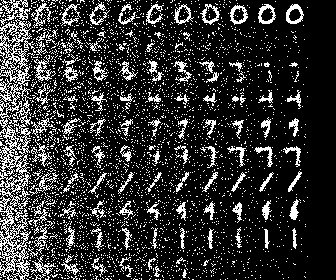

In [10]:
import random

from torchvision.transforms import ToPILImage

transform = ToPILImage()
generated_sample = []

boundary = torch

for idx in random.sample(range(0, num_samples), 10):
    img = []
    img1 = []
    
    for time_step in range(0, config.num_timesteps, 10):
        img.append(sample[time_step, idx,:,:,:]) 
    img.append(sample[-1, idx,:,:,:]) 
    img.append(k1[idx,:,:,:])
    img = torch.cat(img, dim=-1)
    generated_sample.append(img)

generated_sample = torch.cat(generated_sample, dim=1)
transform(generated_sample)

### KAN embedding (10 epochs)

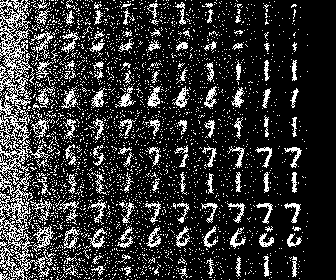

In [6]:
import random

from torchvision.transforms import ToPILImage

transform = ToPILImage()
generated_sample = []

boundary = torch

for idx in random.sample(range(0, num_samples), 10):
    img = []
    img1 = []
    
    for time_step in range(0, config.num_timesteps, 10):
        img.append(sample[time_step, idx,:,:,:]) 
    img.append(sample[-1, idx,:,:,:]) 
    img.append(k1[idx,:,:,:])
    img = torch.cat(img, dim=-1)
    generated_sample.append(img)

generated_sample = torch.cat(generated_sample, dim=1)
transform(generated_sample)